In [43]:
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.datasets import fetch_openml
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.utils import resample
from plotnine import *


from plotnine import *

In [44]:
from sklearn.datasets import fetch_openml
from collections import Counter

credit = fetch_openml('credit-g', parser='auto', version=1)
features = credit.data
target = credit.target

print('Original dataset shape %s' % Counter(target))

Original dataset shape Counter({'good': 700, 'bad': 300})


In [45]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [46]:
target

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: category
Categories (2, object): ['bad', 'good']

In [47]:
def encode_data(features: pd.DataFrame) -> pd.DataFrame:
    # Identify numeric and categorical columns
    numeric_columns = features.select_dtypes(include=['int64', 'float'])
    categorical_columns = features.select_dtypes(exclude=['int64', 'float'])
    
    encoder = OneHotEncoder(handle_unknown='ignore')
    onehot_data = encoder.fit_transform(categorical_columns)
    encoded_data = pd.DataFrame(onehot_data.toarray(), columns=np.concatenate(encoder.categories_))

    combined_data = pd.concat([numeric_columns, encoded_data], axis=1)

    return combined_data

In [48]:
x = encode_data(features)
x.shape, features.shape

((1000, 61), (1000, 20))

In [49]:
x

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,0<=X<200,<0,>=200,...,own,rent,high qualif/self emp/mgmt,skilled,unemp/unskilled non res,unskilled resident,none,yes,no,yes
0,6,1169,4,4,67,2,1,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,48,5951,2,2,22,1,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,12,2096,2,3,49,1,2,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,42,7882,2,4,45,1,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,24,4870,3,4,53,2,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
996,30,3857,4,4,40,1,1,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
997,12,804,4,4,38,1,1,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
998,45,1845,4,4,23,1,1,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [50]:
def encode_target(target: np.array) -> np.array:
    le = LabelEncoder()
    le.fit(target)
    return le.transform(target)

In [51]:
y = encode_target(target)

print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 700, 0: 300})


In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, random_state=13, test_size=0.2, stratify=y)

In [53]:
def cnn_cv(x, y, folds: int = 3, sampling_strategy: float = 0.5) -> tuple:
  predicted = []
  actual = []

  kf = StratifiedKFold(n_splits = folds)
  kf.get_n_splits(x, y)

  for train_index, val_index in kf.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Scale using training data.
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # Undersample with Condensed Nearest Neighbours (CNN).
    cnn = CondensedNearestNeighbour(n_neighbors=n_neighbors)
    x_train, y_train = cnn.fit_resample(x_train, y_train)
    
    # Convert back to DataFrame after CNN
    #x_train = pd.DataFrame(x_train, x.columns)

    # Train LR.
    lr = LogisticRegression(max_iter = 1000).fit(x_train, y_train)

    # Predict on validation set.
    predicted.append(lr.predict_proba(x_val)[:, 1])
    actual.append(y_val)

  actual = np.concatenate(actual)
  predicted = np.concatenate(predicted)
  precision, recall, _ = precision_recall_curve(actual, predicted)

  aucpr = auc(recall, precision)
  aucroc = roc_auc_score(actual, predicted)

  return aucpr, aucroc

In [54]:
def smote_cv(x, y, folds: int = 3, sampling_strategy: float = 0.5) -> tuple:
  predicted = []
  actual = []

  kf = StratifiedKFold(n_splits = folds)
  kf.get_n_splits(x, y)

  for train_index, val_index in kf.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Scale using training data.
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    # Oversample with SMOTE.
    smote = SMOTE(sampling_strategy=sampling_strategy)
    x_train, y_train = smote.fit_resample(x_train, y_train)

    # Train LR.
    lr = LogisticRegression(max_iter = 1000).fit(x_train, y_train)

    # Predict on validation set.
    predicted.append(lr.predict_proba(x_val)[:, 1])
    actual.append(y_val)

  actual = np.concatenate(actual)
  predicted = np.concatenate(predicted)
  precision, recall, _ = precision_recall_curve(actual, predicted)

  aucpr = auc(recall, precision)
  aucroc = roc_auc_score(actual, predicted)

  return aucpr, aucroc

In [55]:
cnn_n_neighbors_values = [1, 2, 3, 4, 5]
smote_sampling_strategy_values = [0.5, 0.6, 0.7, 0.8, 0.9]

In [56]:
cnn_results = {}
smote_results = {}

for n_neighbors in cnn_n_neighbors_values:
    aucpr, aucroc = cnn_cv(x_train, y_train, 3, n_neighbors)
    cnn_results[n_neighbors] = {'AUCPR': aucpr, 'AUCROC': aucroc}

for sampling_strategy in smote_sampling_strategy_values:
    aucpr, aucroc = smote_cv(x_train, y_train, 3, sampling_strategy)
    smote_results[sampling_strategy] = {'AUCPR': aucpr, 'AUCROC': aucroc}

best_cnn_aucpr_param = max(cnn_results, key=lambda k: cnn_results[k]['AUCPR'])
best_smote_aucpr_param = max(smote_results, key=lambda k: smote_results[k]['AUCPR'])

best_cnn_aucroc_param = max(cnn_results, key=lambda k: cnn_results[k]['AUCROC'])
best_smote_aucroc_param = max(smote_results, key=lambda k: smote_results[k]['AUCROC'])

In [57]:
print("CNN Results:")
print("AUCPR and AUCROC results for all CNN hyperparameters:", cnn_results)
print("Best n_neighbors based on AUCPR:", best_cnn_aucpr_param)
print("Best n_neighbors based on AUCROC:", best_cnn_aucroc_param)
print("AUCPR for the best CNN hyperparameters:", cnn_results[best_cnn_aucpr_param]['AUCPR'])
print("AUCROC for the best CNN hyperparameters:", cnn_results[best_cnn_aucpr_param]['AUCROC'])

print("\nSMOTE Results:")
print("AUCPR and AUCROC results for all SMOTE hyperparameters:", smote_results)
print("Best sampling_strategy based on AUCPR:", best_smote_aucpr_param)
print("Best sampling_strategy based on AUCROC:", best_smote_aucroc_param)
print("AUCPR for the best SMOTE hyperparameters:", smote_results[best_smote_aucpr_param]['AUCPR'])
print("AUCROC for the best SMOTE hyperparameters:", smote_results[best_smote_aucpr_param]['AUCROC'])

CNN Results:
AUCPR and AUCROC results for all CNN hyperparameters: {1: {'AUCPR': 0.8461660710941207, 'AUCROC': 0.7322842261904762}, 2: {'AUCPR': 0.8575650394496577, 'AUCROC': 0.7405282738095238}, 3: {'AUCPR': 0.8550276560933094, 'AUCROC': 0.736830357142857}, 4: {'AUCPR': 0.8556465248642513, 'AUCROC': 0.7426339285714286}, 5: {'AUCPR': 0.8566589464720968, 'AUCROC': 0.7432886904761904}}
Best n_neighbors based on AUCPR: 2
Best n_neighbors based on AUCROC: 5
AUCPR for the best CNN hyperparameters: 0.8575650394496577
AUCROC for the best CNN hyperparameters: 0.7405282738095238

SMOTE Results:
AUCPR and AUCROC results for all SMOTE hyperparameters: {0.5: {'AUCPR': 0.8659765056652614, 'AUCROC': 0.7562276785714286}, 0.6: {'AUCPR': 0.8604729926664316, 'AUCROC': 0.7478869047619048}, 0.7: {'AUCPR': 0.8637238501055617, 'AUCROC': 0.7501488095238096}, 0.8: {'AUCPR': 0.8629499330502721, 'AUCROC': 0.7496577380952381}, 0.9: {'AUCPR': 0.8592875671271688, 'AUCROC': 0.7424702380952382}}
Best sampling_strate

### The best number of neigbors for CNN is 2 and it yielded an AUCPR of 0.859 and 0.743 of AUCROC.
### The best sampling startegy for SMOTE is 0.9 with AUCPR value of 0.863 and AUCROC value of 0.749.

In [58]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train Logistic Regression on the training data
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_scaled, y_train)

# Evaluate the model on the test set
predicted = lr.predict_proba(x_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, predicted)
aucpr = auc(recall, precision)
aucroc = roc_auc_score(y_test, predicted)

# Print results
print(f"AUCPR: {aucpr}, AUCROC: {aucroc}")

AUCPR: 0.9144685304933287, AUCROC: 0.8226190476190477


In [59]:
cnn = CondensedNearestNeighbour(n_neighbors=2)
x_train_cnn, y_train_cnn = cnn.fit_resample(x_train_scaled, y_train)

# Train Logistic Regression on the CNN undersampled data
lr_cnn = LogisticRegression(max_iter=1000)
lr_cnn.fit(x_train_cnn, y_train_cnn)

# Evaluate the model on the test set
predicted_cnn = lr_cnn.predict_proba(x_test_scaled)[:, 1]
precision_cnn, recall_cnn, _ = precision_recall_curve(y_test, predicted_cnn)
aucpr_cnn = auc(recall_cnn, precision_cnn)
aucroc_cnn = roc_auc_score(y_test, predicted_cnn)

# Print results
print(f"AUCPR for CNN undersampled data: {aucpr_cnn}")
print(f"AUCROC for CNN undersampled data: {aucroc_cnn}")

AUCPR for CNN undersampled data: 0.9020478870265629
AUCROC for CNN undersampled data: 0.7860714285714285


In [60]:
smote = SMOTE(sampling_strategy=0.9)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

# Train Logistic Regression on the SMOTE oversampled data
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(x_train_smote, y_train_smote)

# Evaluate the model on the test set
predicted_smote = lr_smote.predict_proba(x_test_scaled)[:, 1]
precision_smote, recall_smote, _ = precision_recall_curve(y_test, predicted_smote)
aucpr_smote = auc(recall_smote, precision_smote)
aucroc_smote = roc_auc_score(y_test, predicted_smote)

# Print results
print(f"AUCPR for SMOTE oversampled data: {aucpr_smote}")
print(f"AUCROC for SMOTE oversampled data: {aucroc_smote}")

AUCPR for SMOTE oversampled data: 0.9085498930687235
AUCROC for SMOTE oversampled data: 0.8182142857142858


### 1.4 Based on the AUCPR and AUCROC scores, neither CNN or SMOTE has much improvement on the performance.

### 2.1 Small values of m: For small values of m, the step function has fewer intervals to capture the underlying pattern of the true function 𝒇(x). This may lead to oversimplification and high bias, as the model might not be flexible enough to capture the complexity of 𝒇(x). The model could underfit the data, resulting in a high bias and low variance.

### Large values of m: As m increases, the step function becomes more flexible and can capture more intricate details of 𝒇(x). This increased flexibility may lead to better fitting of the training data, potentially reducing bias. However, with high flexibility comes the risk of fitting noise in the data, leading to higher variance. In this case, the model could overfit the training data, resulting in low bias and high variance.

In [98]:
def f(x: np.array) -> np.array:
    x = np.array(x)
    return np.array(4 * np.sin(np.pi * x) * np.cos(6 * np.pi * x**2))

def generate_fx(n: int = 256, sigma: float = 1) -> np.array:
    x = np.arange(0, 1+1/n, 1/n)
    eps = np.random.normal(loc=0, scale=sigma, size=len(x))
    y = np.array(f(x) + eps)
    return x, y

In [99]:
def fhat(x: np.array, y: np.array, m: int) -> pd.DataFrame:
    n = len(x)
    splits = np.arange(x.min(), x.max(), m/n)
    
    left_x = splits[:-1]
    
    splits_x = pd.cut(pd.Series(x), splits, include_lowest=True, right=True)
    
    yhat = pd.Series(y).groupby(splits_x).mean()
    
    return pd.DataFrame({'x': left_x, 'yhat': yhat.values})

/var/folders/s9/nygm_pjd1g3__t8blbq7mhd00000gn/T/ipykernel_86728/3833950441.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


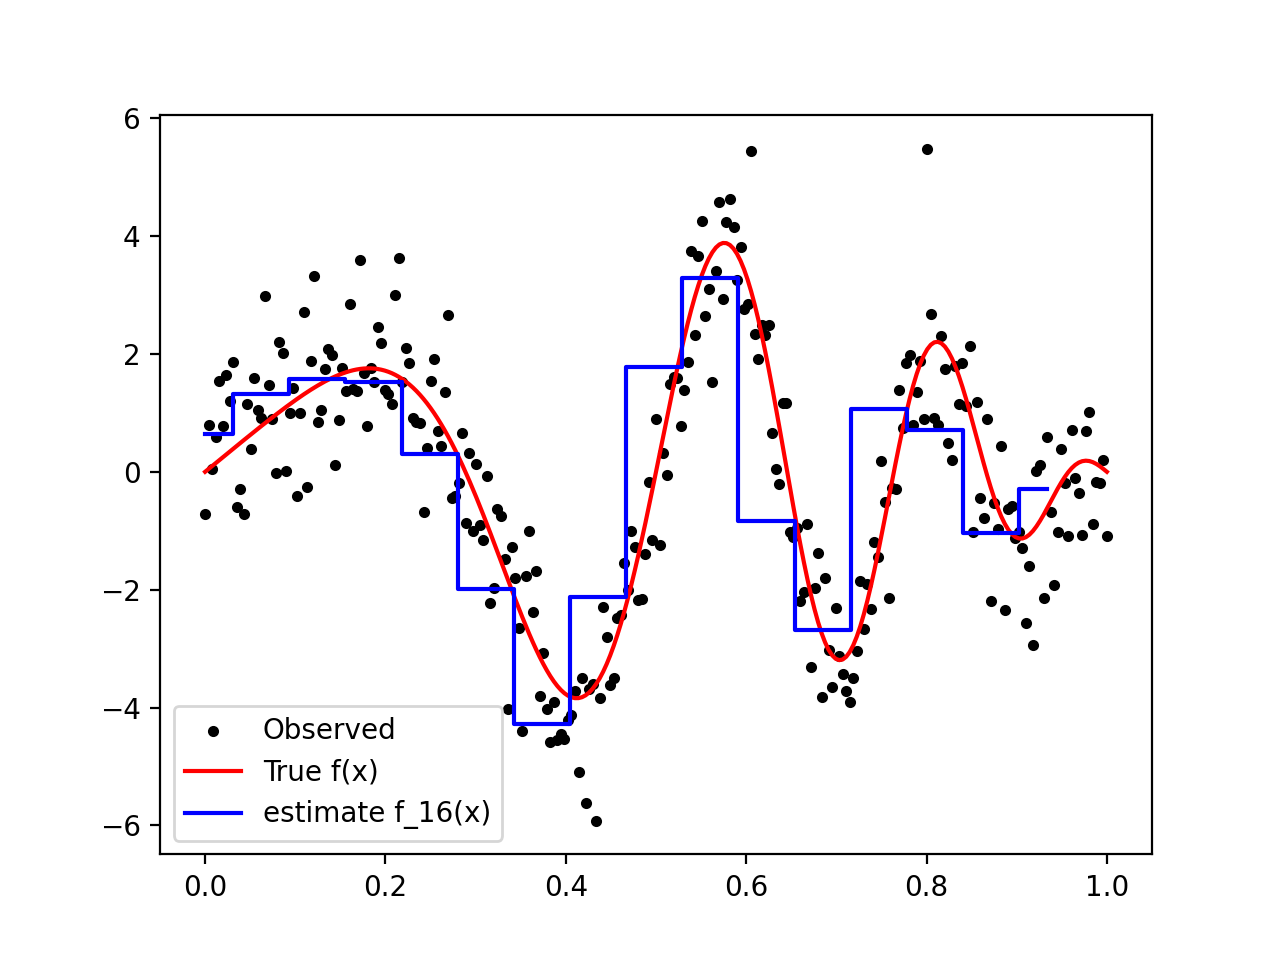

In [100]:
np.random.seed(13)

# Simulation parameters
n = 256
m = 16
sigma = 1.0

x, y = generate_fx(n, sigma)

fh = fhat(x, y, m)
plt.scatter(x, y, label='Observed', color='black', marker='.')

true_fx = 4 * np.sin(np.pi * x) * np.cos(6 * np.pi * x**2)
plt.plot(x, true_fx, label='True f(x)', color='red')

#plt.plot(fh['x'], fh['yhat'], label='Estimated f_16(x)', color='blue')
plt.step(fh['x'], fh['yhat'], where='mid', label='estimate f_16(x)', color='blue')

plt.legend()
plt.show()

In [101]:
def fbar(j: int, m: int, n: int=256) -> float:
    x = generate_x(n)
    fx = f(x)
    i = np.arange((j-1) * m, j * m, dtype=int)
    return np.mean(fx[i])

In [102]:
def avgbiassq(m:int, n: int=256) -> float:
    biassq = 0
    x = generate_x(n)
    fx = f(x)
    for j in np.arange(1, n/m+1, dtype =int):
        i = np.arange((j-1) *m, j * m, dtype=int)
        biassq += np.sum((fbar(j, m) - fx[i])**2)
    return biassq/n

In [103]:
def avgvar(m:int, sigma: float=1) -> float:
    return sigma**2/m

In [104]:
def total_error(m: int, sigma: float=1, n: int=256) -> float:
    return avgbiassq(m, n) + avgvar(m, sigma)

In [105]:
def empirical_error(x: np.array, fit: pd.DataFrame) -> float:
    z = f(x)
    fhat_new = np.zeros(len(x))
    for i in range(len(x)):
        fhat_new[i] = fit.yhat[np.max(np.where(fit.x <= new_x[i]))]
    return np.mean((z - fhat_new)**2)

In [106]:
new_x = np.random.uniform(size=1000)
n = 256
sigma = 1.0

random_state = 13

results = pd.DataFrame()
m = np.array([1,2,4,8,16,32])

for i in range(len(m)):
    x, y = generate_fx(n, sigma)
    fit = fhat(x, y, m[i])
    emperr = empirical_error(new_x, fit)
    biassq = avgbiassq(m[i], n)
    var = avgvar(m[i], sigma)
    total = total_error(m[i], sigma, n)
    results_i = pd.DataFrame({
        'm': [m[i]],
        'empirical_error': [emperr],
        'avgbiasq': [biassq],
        'avgvar': [var],
        'total_error': [total]
    })
    results = pd.concat([results, results_i])
results

/var/folders/s9/nygm_pjd1g3__t8blbq7mhd00000gn/T/ipykernel_86728/3833950441.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,m,empirical_error,avgbiasq,avgvar,total_error
0,1,0.865668,0.000000,1.00000,1.000000
0,2,0.497755,0.006300,0.50000,0.506300
0,4,0.298168,0.031378,0.25000,0.281378
0,8,0.244378,0.129793,0.12500,0.254793
0,16,0.554071,0.492575,0.06250,0.555075
0,32,1.023061,0.961387,0.03125,0.992637


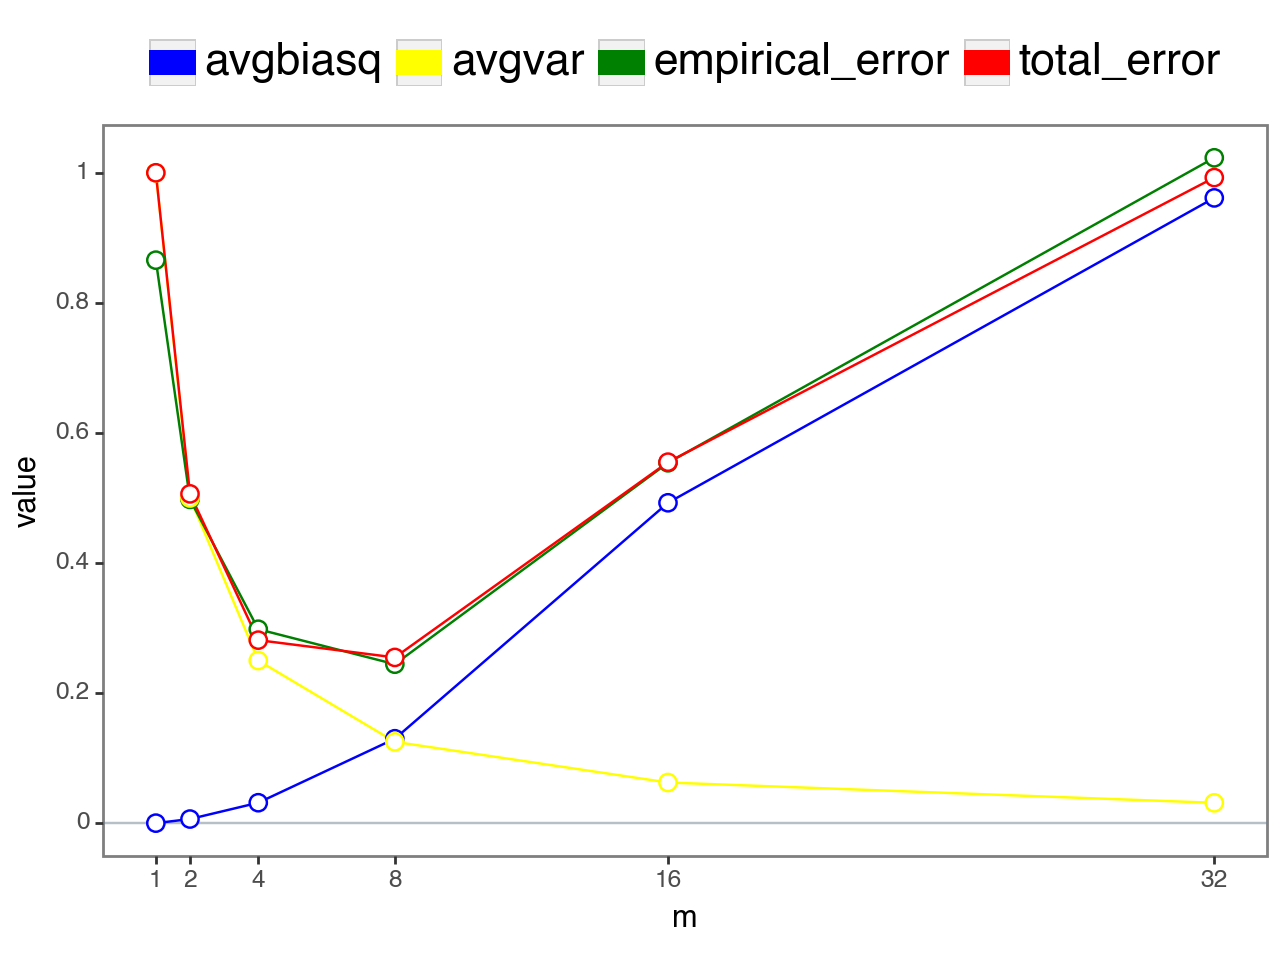

<Figure Size: (640 x 480)>

In [107]:
results_long = results.melt(id_vars='m')

(
    ggplot(results_long, aes(x='m', y='value')) +
    geom_hline(yintercept=0, color='slategray', alpha=0.5) +
    geom_line(aes(color='variable')) +
    geom_point(aes(color='variable'), show_legend=False, fill='white', size=3) +
    scale_x_continuous(breaks=list(results['m'])) +  # Use list() to convert m to a list
    scale_y_continuous(breaks=np.arange(0, 1.1, 0.2)) +
    scale_color_manual(values=['blue', 'yellow', 'green', 'red']) +
    theme_bw() +
    theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        legend_title=element_blank(),
        legend_position='top',  # Corrected typo: 'lenged_position' to 'legend_position'
        legend_box_background=element_blank(),
        legend_text=element_text(size=16)
    ) +
    guides(color=guide_legend(override_aes={'size': 5}))
)
   